- quelle taille de patch ?
- textures ?
- quel type de performance ? vitesse, efficacité, résultat?

- faire le test de rotation pour chaque patch

In [ ]:
import glob
import time
import numpy as np
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
from scipy import spatial
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.io import imread,imshow
import time

In [ ]:
model_name16 = "openai/clip-vit-base-patch16" # you can change model name here with patch size -- search in Hugging face.
model16 = CLIPModel.from_pretrained(model_name16)
processor16 = CLIPProcessor.from_pretrained(model_name16)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
model_name32 = "openai/clip-vit-base-patch32" # you can change model name here with patch size -- search in Hugging face.
model32 = CLIPModel.from_pretrained(model_name32)
processor32 = CLIPProcessor.from_pretrained(model_name32)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
model_name14 = "openai/clip-vit-large-patch14" # you can change model name here with patch size -- search in Hugging face.
model14 = CLIPModel.from_pretrained(model_name14)
processor14 = CLIPProcessor.from_pretrained(model_name14)

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
classes = [
    "airplane", "ball", "car", "cat", "dolphin",
    "face", "lotus", "pickles"]

captions = [f"a picture of a {label}" for label in classes]

In [ ]:
query_paths = sorted(glob.glob('./*.jpg'))
database_paths = sorted(glob.glob('./database/*.jpg'))

In [ ]:
def pre_processing(classes, path_list, processor) :
  captions = [f"a picture of a {label}" for label in classes]
  images = [Image.open(img).convert("RGB") for img in path_list]
  return  processor(text=captions, images=images, return_tensors="pt", padding=True)

In [ ]:
def run_model (inputs, model) :
  with torch.no_grad():
        outputs = model(**inputs)
  return outputs

In [ ]:
def embed_image_list (classes, path_list,model, processor) :

  inputs = pre_processing(classes,path_list, processor)

  outputs = run_model (inputs, model)

  embedded_list = []

  features = outputs.image_embeds.cpu().numpy()

  for i in range(0,len(features)) :
    embedded_list.append((features[i], path_list[i].split('/')[-1]))

  return embedded_list

In [ ]:
query_embedding16 = embed_image_list(classes,query_paths,model16, processor16)
database_embedding16 = embed_image_list(classes,database_paths,model16, processor16)

In [ ]:
query_embedding32 = embed_image_list(classes,query_paths,model32, processor32)
database_embedding32 = embed_image_list(classes,database_paths,model32, processor32)

In [ ]:
query_embedding14 = embed_image_list(classes,query_paths,model14, processor14)
database_embedding14 = embed_image_list(classes,database_paths,model14, processor14)

In [ ]:
def get_scores(metric, query_list, db_list) :
    score_list = []

    for q in query_list :
        l = []
        for im in db_list :
           score = 0
           if (metric == "cosine") :
               score = spatial.distance.cosine(q[0],im[0])
           elif (metric == "canberra") :
                 score = spatial.distance.canberra(q[0],im[0])
           l.append((score,im[1]))
        l.sort(key = lambda x : x[0])
        score_list.append({"name" : q[1], "score_list" : l})
    return score_list

In [ ]:
cosine_scores16 = get_scores('cosine', query_embedding16, database_embedding16)
print(cosine_scores16)

cosine_scores32 = get_scores('cosine', query_embedding32, database_embedding32)
print(cosine_scores32)

cosine_scores14 = get_scores('cosine', query_embedding14, database_embedding14)
print(cosine_scores14)

[{'name': 'airplane_query.jpg', 'score_list': [(0.133599144244114, 'airplane_3.jpg'), (0.1514187455177307, 'airplane_2.jpg'), (0.16173213720321655, 'airplane_5.jpg'), (0.1892851478287475, 'airplane_1.jpg'), (0.20476493849649802, 'airplane_4.jpg'), (0.3758628182370308, 'car_1.jpg'), (0.38242924213409424, 'car_5.jpg'), (0.39677594294476315, 'cat_1.jpg'), (0.39722931385040283, 'cat_4.jpg'), (0.40416502952575684, 'dolphin_3.jpg'), (0.4051108956336975, 'cat_3.jpg'), (0.40553945302963257, 'car_4.jpg'), (0.4074408831429742, 'ball_3.jpg'), (0.4142373625706838, 'car_3.jpg'), (0.4154593596136178, 'cat_2.jpg'), (0.41882382091354764, 'ball_4.jpg'), (0.4252405509209294, 'lotus_1.jpg'), (0.42714717549962755, 'dolphin_1.jpg'), (0.4351967313768418, 'ball_2.jpg'), (0.448349151113679, 'dolphin_4.jpg'), (0.4500772953033447, 'cat_5.jpg'), (0.4533010721206665, 'ball_5.jpg'), (0.45401740074157715, 'ball_1.jpg'), (0.45649481338324005, 'car_2.jpg'), (0.46101566916797476, 'dolphin_5.jpg'), (0.47869376774709704

# Get Time


In [ ]:
def get_time (inputs, model) :
    start_time = time.time() #Getting the elapsed time
    run_model(inputs, model)
    end_time = time.time()
    return end_time - start_time

In [ ]:
def pics_time(processor, model) :
  time_table = []

  #1 pic
  one_pic_time = get_time(pre_processing(classes,query_paths[:1], processor), model)
  time_table.append(one_pic_time)

  #5 pics
  five_pic_time = get_time(pre_processing(classes,query_paths[:5], processor), model)
  time_table.append(five_pic_time)

  #10 pics
  ten_pic_time = get_time(pre_processing(classes,database_paths[:10], processor), model)
  time_table.append(ten_pic_time)

  #25 pics
  twenty_five_pic_time = get_time(pre_processing(classes,database_paths[:25], processor), model)
  time_table.append(twenty_five_pic_time)

  #total (48 pics)
  combined_path_array = query_paths + database_paths
  all_pics_time = get_time(pre_processing(classes,combined_path_array, processor), model)
  time_table.append(all_pics_time)

  time_table = np.round(time_table, 2)

  return time_table

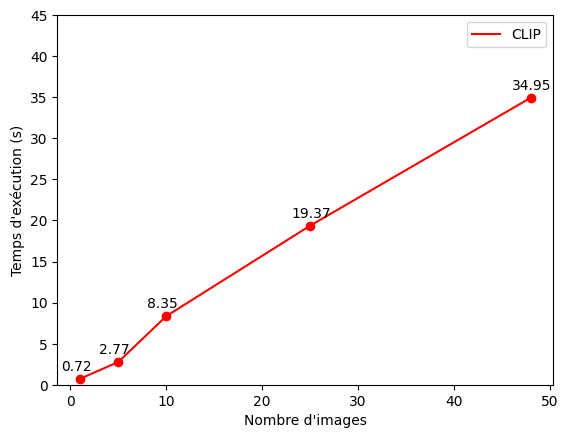

In [ ]:
#for path16

#Plotting the results
times16 = pics_time(processor16, model16)
plt.xlabel("Nombre d'images")
plt.ylabel("Temps d'exécution (s)")
nb_images = [1,5,10,25,48]
plt.scatter(nb_images, times16, color = 'red')
plt.plot(nb_images, times16, label = 'CLIP', color = 'red')
plt.ylim(0, 45)
for i, txt in enumerate(times16):
    plt.annotate(str(txt), (nb_images[i] - 2, times16[i] + 1))
plt.legend()
plt.show()

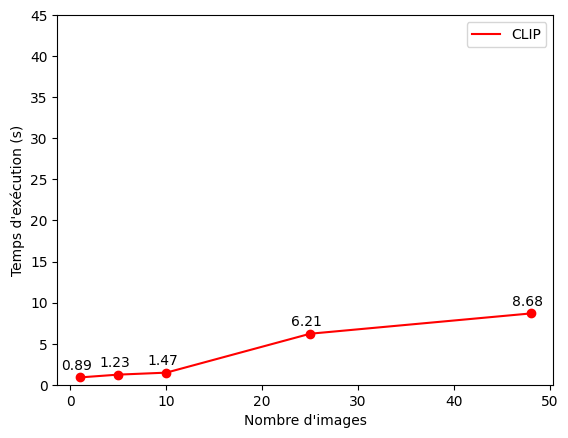

In [ ]:
#for path32

#Plotting the results
times32 = pics_time(processor32, model32)
plt.xlabel("Nombre d'images")
plt.ylabel("Temps d'exécution (s)")
nb_images = [1,5,10,25,48]
plt.scatter(nb_images, times32 , color = 'red')
plt.plot(nb_images, times32 , label = 'CLIP', color = 'red')
plt.ylim(0, 45)
for i, txt in enumerate(times32):
    plt.annotate(str(txt), (nb_images[i] - 2, times32 [i] + 1))
plt.legend()
plt.show()

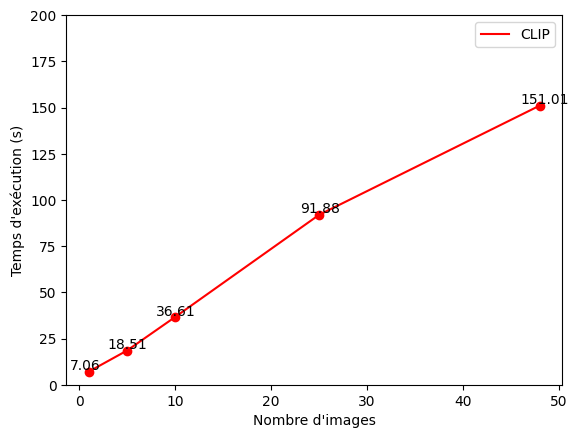

In [ ]:
#for path14

#Plotting the results
times14 = pics_time(processor14, model14)
plt.xlabel("Nombre d'images")
plt.ylabel("Temps d'exécution (s)")
nb_images = [1,5,10,25,48]
plt.scatter(nb_images, times14, color = 'red')
plt.plot(nb_images, times14, label = 'CLIP', color = 'red')
plt.ylim(0, 200)
for i, txt in enumerate(times14):
    plt.annotate(str(txt), (nb_images[i] - 2, times14[i] + 1))
plt.legend()
plt.show()

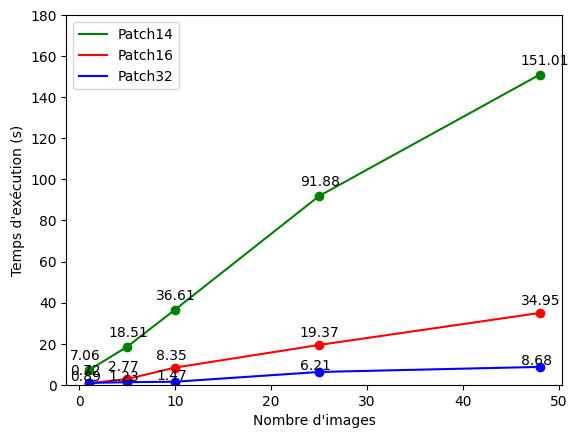

In [ ]:
#graphe avec les trois temps d'execution
#Plotting the results
plt.xlabel("Nombre d'images")
plt.ylabel("Temps d'exécution (s)")
nb_images = [1,5,10,25,48]

plt.scatter(nb_images, times14, color = 'green')
plt.plot(nb_images, times14, label = 'Patch14', color = 'green')
plt.ylim(0, 180)
for i, txt in enumerate(times14):
    plt.annotate(str(txt), (nb_images[i] - 2, times14[i] + 5))

plt.scatter(nb_images, times16, color = 'red')
plt.plot(nb_images, times16, label = 'Patch16', color = 'red')
for i, txt in enumerate(times16):
    plt.annotate(str(txt), (nb_images[i] - 2, times16[i] + 4))

plt.scatter(nb_images, times32, color = 'blue')
plt.plot(nb_images, times32, label = 'Patch32', color = 'blue')
for i, txt in enumerate(times32):
    plt.annotate(str(txt), (nb_images[i] - 2, times32[i] + 1))

plt.legend()
plt.show()
